<h1>Лабораторная работа 1</h1>
Енгоян Сергей А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br> 
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [2]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)
    a2 = np.random.uniform(0.5, 1.0)

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.cos(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        return result
    elif num == 2:
        for i in range(N):
            result.append(abs(e[i]) ** (0.1 * t[i]) + 2 * abs(e[i]))
        return result

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [3]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [4]:
def diffs(X):
    X = np.array(X, dtype=float)
    N = len(X)

    diff_x = np.full(N, np.nan)  # разница с предыдущим
    diff_y = np.full(N, np.nan)  # разница с следующим

    # начиная со второго элемента до последнего, считаем разницу с предыдущим
    diff_x[1:-1] = X[1:-1] - X[0:-2]

    # начиная со второго до предпоследнего, считаем разницу с следующим
    diff_y[1:-1] = X[2:] - X[1:-1]

    return diff_x, diff_y

In [5]:
def ellips(y1, PARAM):
    # === 1. Приращения ===
    dx, dy = diffs(y1)

    # === 2. Очистка от NaN ===
    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    # === 3. Центр выборки ===
    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    # === 4. Ковариационная матрица ===
    cov = np.cov(dx_clean, dy_clean)

    # === 5. Главные оси ===
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # === 6. Размеры эллипса ===
    confidence_val = chi2.ppf(PARAM, df=2)
    width, heigth = 2 * np.sqrt(confidence_val * vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    el = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=heigth,
        angle=angle,
        edgecolor='r',
        facecolor='none',
        lw=2
    )

    # === 7. Махаланобисово расстояние ===
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # === 8. Отбор аномалий (2-й и 4-й квадрант относительно (0,0)) ===
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))
    outliers_mask = (mahal_sq > confidence_val) & in_quadrant

    # === 9. Координаты и индексы аномалий ===
    outlier_x = dx_clean[outliers_mask]
    outlier_y = dy_clean[outliers_mask]
    outlier_indices = np.where(mask)[0][outliers_mask]

    # === 10. Печать аномалий ===
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        print(f"{idx} : {y1[idx]} {x} {y}")

    # === 11. Визуализация ===
    fig, ax = plt.subplots()
    ax.spines['left'].set_position(('data', mean_x))
    ax.spines['bottom'].set_position(('data', mean_y))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(outlier_x, outlier_y, color='orange', s=30, label='Аномалии')

    # Подписи индексов у оранжевых точек
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        ax.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    ax.add_patch(el)
    ax.legend()
    plt.show()

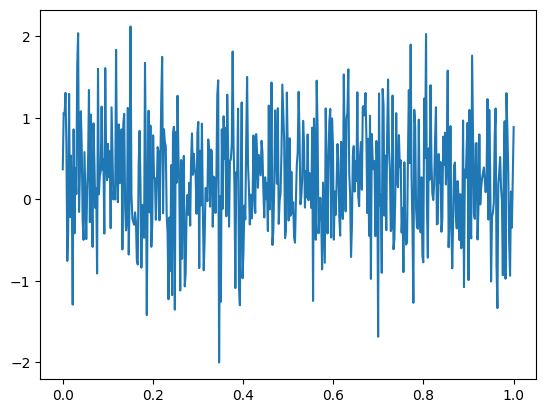

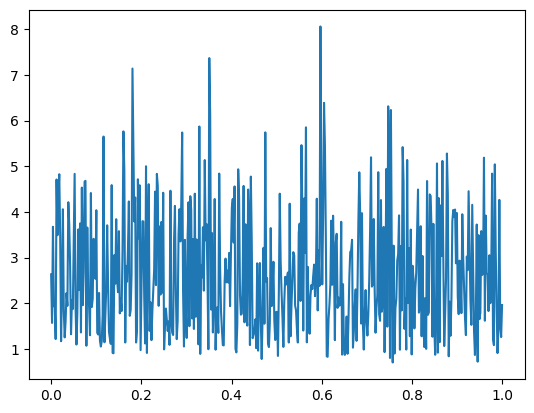

In [6]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

172 : 1.4620483621309455 0.18277741195335495 -3.461876980695694
173 : -1.9998286185647487 -3.461876980695694 2.0376497730872702
349 : -1.6843334201952804 -2.1756286419391078 2.9859127422608314
350 : 1.301579322065551 2.9859127422608314 -1.3766963274965185


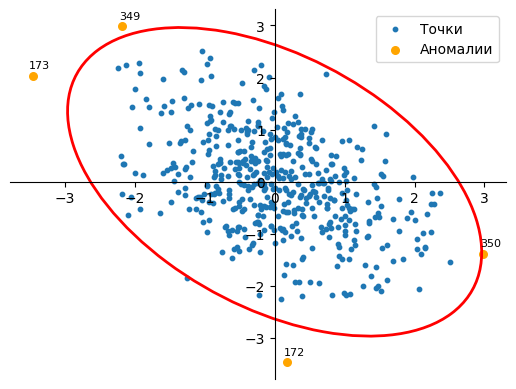

164 : 5.868645638059277 4.76727595161571 -4.9766231615173275
174 : 0.9941374947115105 -1.6011821089754916 6.372190208596531
175 : 7.366327703308041 6.372190208596531 -1.2445823732216805
297 : 2.3802613662768315 -0.7785642221126028 5.677827869840055
298 : 8.058089236116887 5.677827869840055 -3.599597728935864
375 : 0.8030035712885943 -4.468593015474059 5.42698349621577


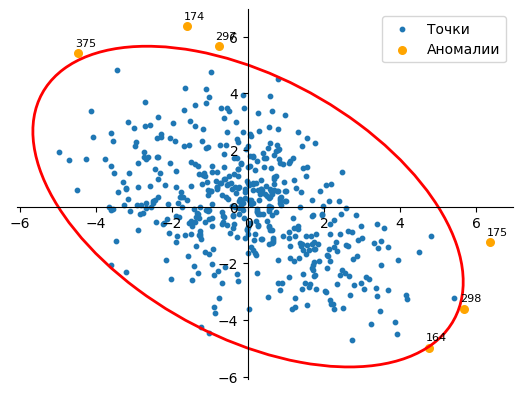

In [7]:
PARAM = 0.99

ellips(y1, PARAM)

ellips(y2, PARAM)

<h3>3) Исследование стационарности</h3>

In [9]:
def stat_analys(X, num=1):

    up_down = []

    for i in range(1, len(X)):
        if X[i] - X[i-1] > 0:
            up_down.append("+")
        elif X[i] - X[i-1] < 0:
            up_down.append("-")
        else:
            continue
    
    up_trends, max_up = 0, 0
    down_trends, max_down = 0, 0
    current_length = 1
    
    for i in range(1, len(up_down)):
        if up_down[i] == up_down[i-1]:
            current_length += 1
        else:
            if up_down[i-1] == "+":
                up_trends += 1
                max_up = max(max_up, current_length)
            else:
                down_trends += 1
                max_down = max(max_down, current_length)
            current_length = 1
    
        if up_down[-1] == "+":
            up_trends += 1
            max_up = max(max_up, current_length)
    else:
        down_trends += 1
        max_down = max(max_down, current_length)
    
    return {
        "up_trends": up_trends,
        "down_trends": down_trends,
        "max_up": max_up,
        "max_down": max_down
    }

In [10]:
res = stat_analys(y1)
print(res)

{'up_trends': 655, 'down_trends': 158, 'max_up': 5, 'max_down': 5}
